# Iris

![Iris](iris.jpg)

&nbsp;

### Iris flower dataset: [link to Wikipedia (click-me)](https://en.wikipedia.org/wiki/Iris_flower_data_set)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import seaborn as sns
from sklearn import datasets, model_selection as ms, linear_model as lm
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm

### Validation Preferences

In [2]:
FOLDS = 5
TEST_SIZE = 1/4

### Load Data

In [3]:
iris = datasets.load_iris()
df = pd.DataFrame(iris["data"], columns=iris["feature_names"])
df["target"] = iris["target"]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


### Data Exploration

In [4]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [5]:
target_map = {0: "setosa", 1: "versicolor", 2: "virginica"}
df["target_name"] = df["target"].map(target_map)
df.groupby("target_name").describe()

sepal length (cm)                                              \
                        count   mean       std  min    25%  50%  75%  max   
target_name                                                                 
setosa                   50.0  5.006  0.352490  4.3  4.800  5.0  5.2  5.8   
versicolor               50.0  5.936  0.516171  4.9  5.600  5.9  6.3  7.0   
virginica                50.0  6.588  0.635880  4.9  6.225  6.5  6.9  7.9   

            sepal width (cm)         ... petal width (cm)      target       \
                       count   mean  ...              75%  max  count mean   
target_name                          ...                                     
setosa                  50.0  3.428  ...              0.3  0.6   50.0  0.0   
versicolor              50.0  2.770  ...              1.5  1.8   50.0  1.0   
virginica               50.0  2.974  ...              2.3  2.5   50.0  2.0   

                                           
             std  min  25%  50%  75%  max  
target_name                                
setosa       0.0  0.0  0.0  0.0  0.0  0.0  
versicolor   0.0  1.0  1.0  1.0  1.0  1.0  
virginica    0.0  2.0  2.0  2.0  2.0  2.0  

[3 rows x 40 columns]

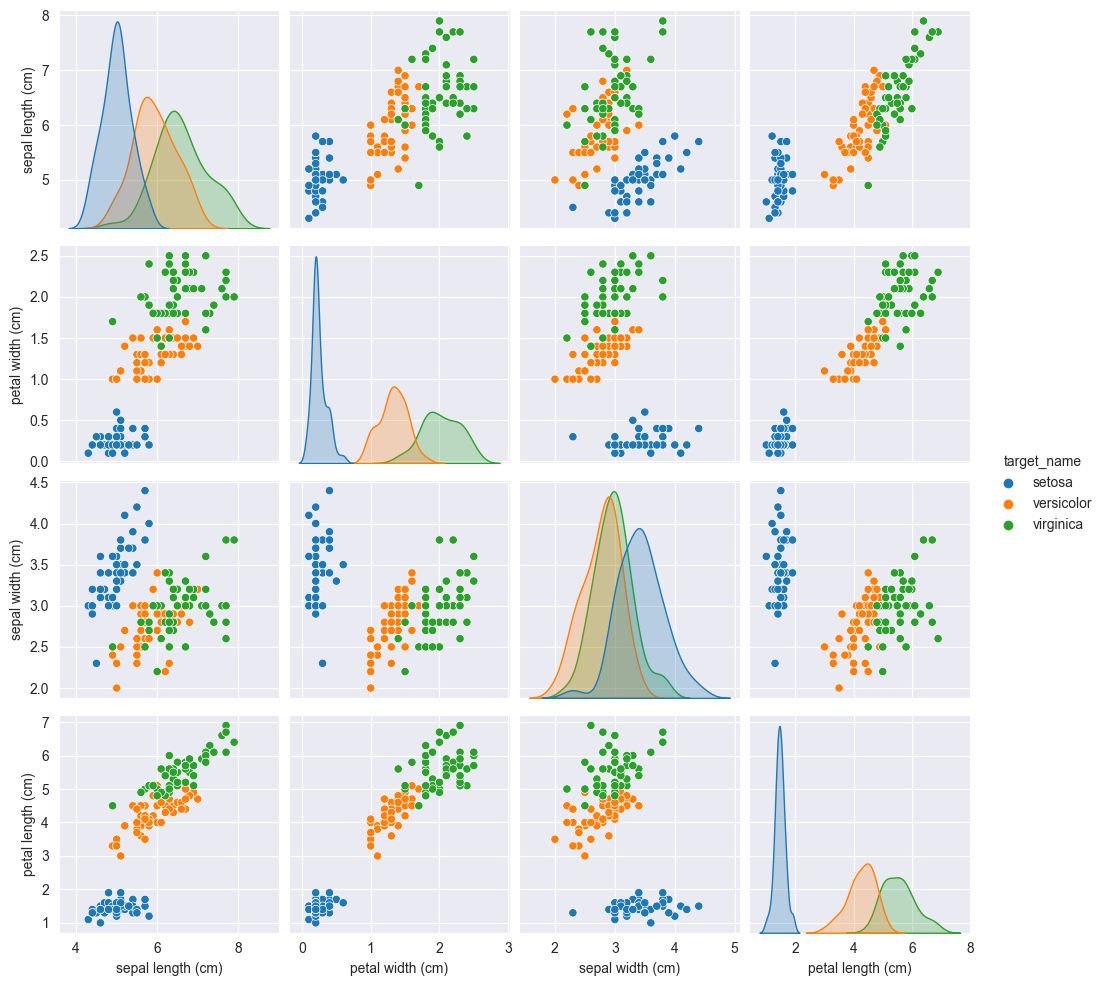

In [6]:
agent_cols = ["target", "target_name"]
pp_cols = list(set(df.columns) - set(agent_cols))
color_emphasis = "target_name"
sns.pairplot(df, x_vars=pp_cols, y_vars=pp_cols,  hue=color_emphasis)

### Train-Test Split

In [7]:
x_train = df.drop(columns=["target", "target_name"])
y_train = df["target"].values

### Singe Feature Prediction: baseline

In [8]:
# Copy the original dataset
df_sf = df.copy()

In [9]:
def petal_length_classification(sepal_len: float) -> str:
    """Simplest single feature prediction."""
    # Setosa has the shortest petal
    if sepal_len < 3.0:
        return "setosa"
    # Virginica has the longest petal
    elif sepal_len > 4.8:
        return "virginica"
    # Other is Versicolor
    return "versicolor"
# Apply over the df
df_sf["decision"] = df_sf["petal length (cm)"].apply(petal_length_classification)
# Calculate accuracy
sf_count_equal = (df_sf['decision'] == df_sf['target_name']).sum()
sf_model_score = sf_count_equal / len(df_sf)
f"Hardcoded model accuracy: {sf_model_score:.3%}"

'Hardcoded model accuracy: 95.333%'

### Logistic Regression

In [10]:
# Copy the original dataset
df_lr = df.copy()
# Logistic regression model hyperparameters
lr_max_iter = 200
regularisation = 5.4
# Train-test split
xt, xv, yt, yv = ms.train_test_split(x_train, y_train, test_size=TEST_SIZE)
# Logistic regression model
lr_model = lm.LogisticRegression(max_iter=lr_max_iter, C=regularisation)
lr_model_x_val = ms.cross_val_score(lr_model, x_train, y_train, cv=FOLDS, scoring="accuracy")
lr_model_score = np.mean(lr_model_x_val)
f"Logistic regression classifier accuracy: {lr_model_score:.3%}"

'Logistic regression classifier accuracy: 98.000%'

In [11]:
# Tuning discovery loop
do_tuning = False
if do_tuning:
    # Collect the accuracies
    tuning_accuracies = []
    for i_reg in tqdm(range(1, 501)):
        i_reg *= 0.05
        i_model = lm.LogisticRegression(max_iter=lr_max_iter, C=i_reg)
        tuning_accuracies.append((
            i_reg,
            np.mean(ms.cross_val_score(i_model, x_train, y_train, cv=FOLDS, scoring="accuracy"))
        ))
    # Find the most optimal regularisation
    df_tuning = pd.DataFrame(tuning_accuracies, columns=["regularisation", "accuracy"])
    max_acc_index = df_tuning["accuracy"].idxmax()

    best_reg = df_tuning.loc[max_acc_index, "regularisation"]
    print(f"Best regularization = {best_reg}")
    # Plot tuning results
    plt.plot(df_tuning["regularisation"], df_tuning["accuracy"])
    plt.xlabel('Regularisation')
    plt.ylabel('Accuracy')
    plt.show()

In [12]:
lr_predict = ms.cross_val_predict(lr_model, x_train, y_train, cv=FOLDS)
df_lr["prediction"] = lr_predict
df_lr["is_prediction_correct"] = lr_predict == y_train
df_lr["prediction_label"] = df_lr["prediction"].map(target_map)
df_lr[df_lr["prediction"]==False].head(2)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name,prediction,is_prediction_correct,prediction_label
0,5.1,3.5,1.4,0.2,0,setosa,0,True,setosa
1,4.9,3.0,1.4,0.2,0,setosa,0,True,setosa


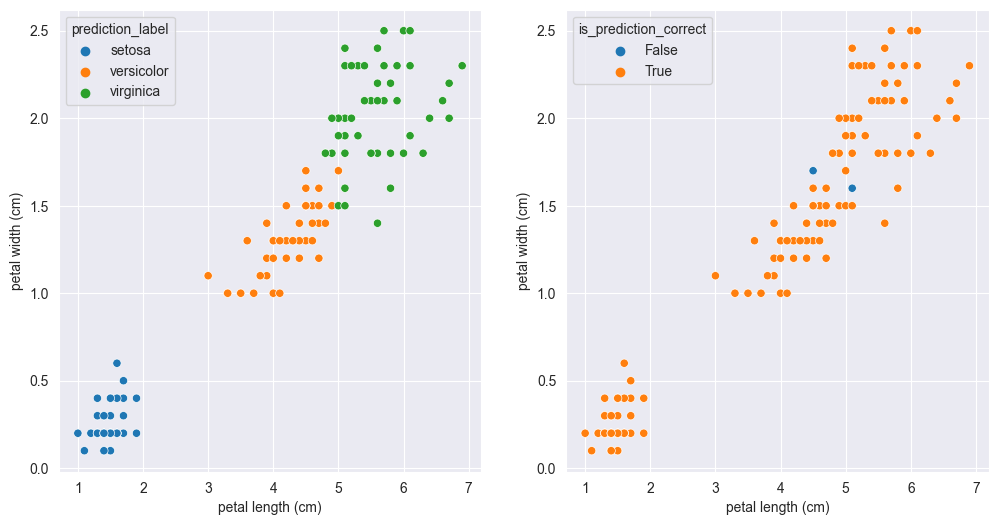

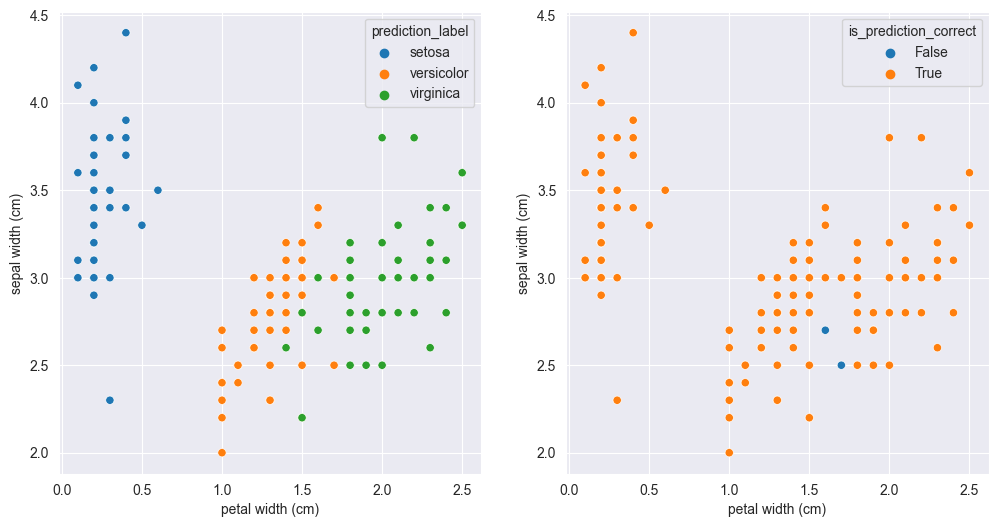

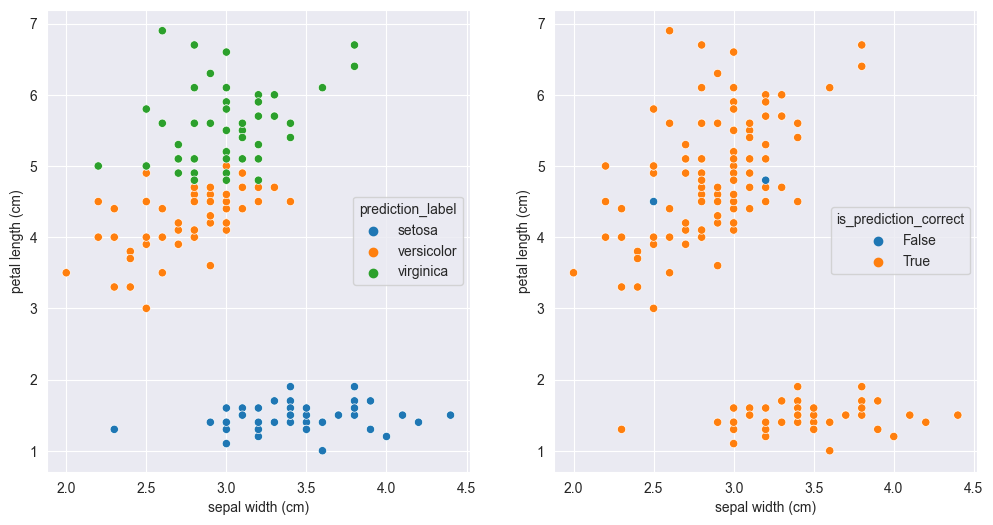

In [13]:
def plot_incorrect_predictions(df_param, x_feat, y_feat):
    """# Plot specific pairs with an emphasis on errors."""
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs = axs.flatten()
    sns.scatterplot(x=x_feat, y=y_feat, hue="prediction_label", data=df_param, ax=axs[0])
    sns.scatterplot(x=x_feat, y=y_feat, hue="is_prediction_correct", data=df_param, ax=axs[1])
    plt.show()
# Show all pairs
plot_incorrect_predictions(df_lr, "petal length (cm)", "petal width (cm)")
plot_incorrect_predictions(df_lr, "petal width (cm)", "sepal width (cm)")
plot_incorrect_predictions(df_lr, "sepal width (cm)", "petal length (cm)")

### Random Forest

In [14]:
# Copy the original dataset
df_rf = df.copy()
# Random Forest model
rf_model = RandomForestClassifier()
rf_model_x_val = ms.cross_val_score(rf_model, x_train, y_train, cv=FOLDS, scoring="accuracy")
rf_model_score = np.mean(rf_model_x_val)
f"Random Forest classifier accuracy: {rf_model_score:.3%}"

'Random Forest classifier accuracy: 96.667%'

In [15]:
rf_predict = ms.cross_val_predict(rf_model, x_train, y_train, cv=FOLDS)
df_rf["prediction"] = rf_predict
df_rf["is_prediction_correct"] = rf_predict == y_train
df_rf["prediction_label"] = df_rf["prediction"].map(target_map)
df_rf[df_rf["prediction"]==False].head(2)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name,prediction,is_prediction_correct,prediction_label
0,5.1,3.5,1.4,0.2,0,setosa,0,True,setosa
1,4.9,3.0,1.4,0.2,0,setosa,0,True,setosa


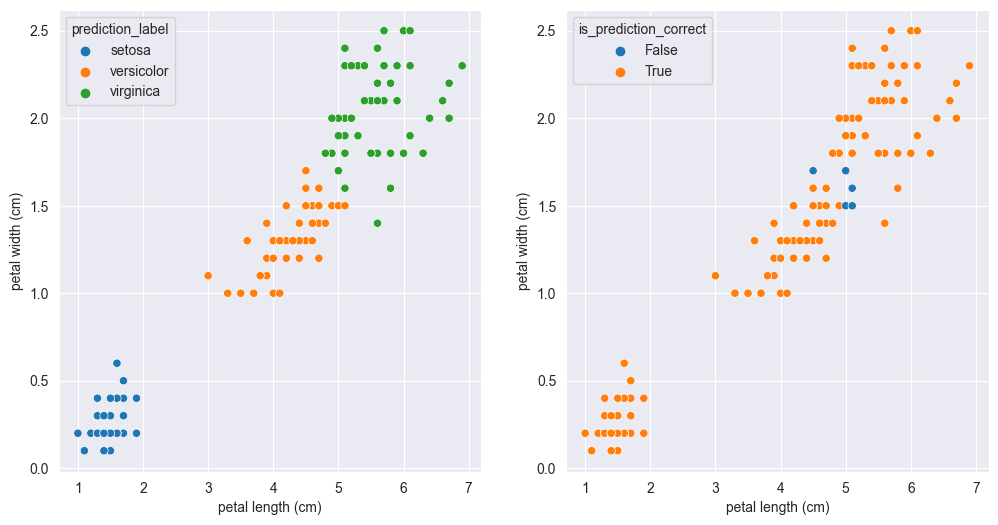

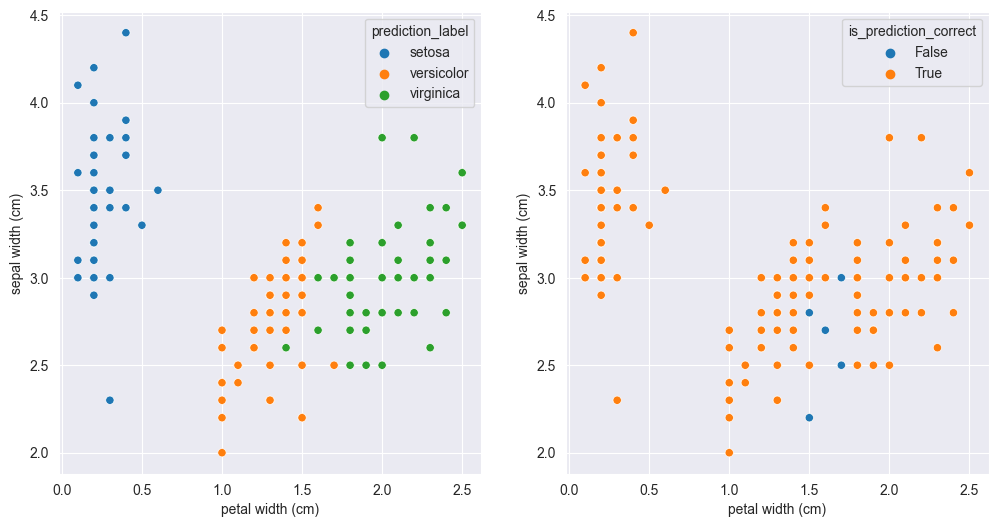

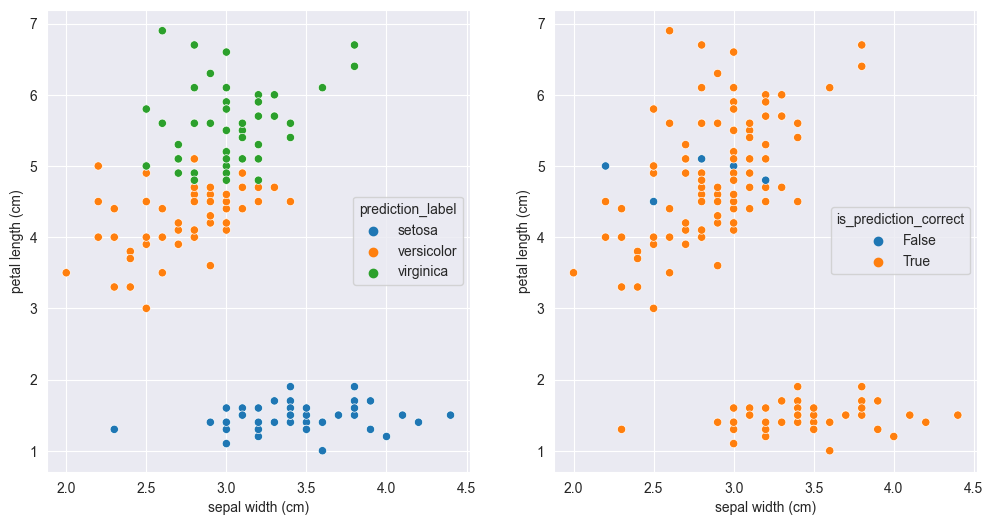

In [16]:
# Show all pairs
plot_incorrect_predictions(df_rf, "petal length (cm)", "petal width (cm)")
plot_incorrect_predictions(df_rf, "petal width (cm)", "sepal width (cm)")
plot_incorrect_predictions(df_rf, "sepal width (cm)", "petal length (cm)")